Prepare and analyze the cosine similarity results

In [115]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz, load_npz
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
# What to do with this? Generate examples for all!

# Look at examples, what is our cos sim threshold?
# Remove where both are -1? and both are 0?
# Which codes appear most often?
# Which codes appear most often when agreement?
# Which codes appear most often in disagreement?
# Look at sentences that are exactly the same: how often is there disagreement?
# What changes if we limit to combinations by different coders/from different documents?
# in 0/-1 codes: how often do coders agree, that there is no meaning in this?

In [117]:
# Set display options to show full contents of each column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# reverse with:
# pd.reset_option('display.max_colwidth')

In [118]:
# load the sparse matrix with the extreme similarity values:
cs_sparse = load_npz('data/cos_sim_output_08_mpnet.npz')

# also load the full corpus df, so that we can add create a df with q_sentences, information and their similarity score for extreme values
corpus_df_full = pd.read_csv("data/english_annotated_full_df.csv")

In [119]:
cs_sparse

<202187x202187 sparse matrix of type '<class 'numpy.float32'>'
	with 379546 stored elements in Compressed Sparse Row format>

In [120]:
# convert the sparse matrix into a useful df:
cs_sparse = coo_matrix(cs_sparse)
data = {
    'index_x': cs_sparse.row,
    'index_y': cs_sparse.col,
    'cosine_similarity': cs_sparse.data
}
cosine_sim_df = pd.DataFrame(data)

In [121]:
cosine_sim_df.head(2)

,index_x,index_y,cosine_similarity
0,7,9,0.851987
1,7,119,0.903366


In [122]:
cosine_sim_df.shape

(379546, 3)

In [123]:
corpus_df = corpus_df_full[['q_sentence', "q_sentence_nr", 'main_codes', 'coderid', 'manifesto_id', 'party', 'date',
        'title', 'countryname', 'partyname', 'RILE']]

In [124]:
# append the columns from the corpus_df, so that we get the info for both quasi sentences
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_x', right_index=True, how='left')
cosine_sim_df = pd.merge(cosine_sim_df, corpus_df, left_on='index_y', right_index=True, how='left')

In [125]:
cosine_sim_df.head(3)

,index_x,index_y,cosine_similarity,q_sentence_x,q_sentence_nr_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,countryname_x,partyname_x,RILE_x,q_sentence_y,q_sentence_nr_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y
0,7,9,0.851987,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Key priorities are to:,10,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
1,7,119,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,120,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0
2,7,215,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,216,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0


In [126]:
# How many values do we have that are below -0.8?
cosine_sim_df[cosine_sim_df["cosine_similarity"] < 0].shape
# --> none of them!

(0, 25)

In [127]:
cosine_sim_df.shape

(379546, 25)

Looking at the lowest cosine similarities. Are they good enough?

In [128]:
# cosine_sim_df.sort_values(by="cosine_similarity",
#                           ascending=True)[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y", "cosine_similarity"]].head(20)

cosine_sim_df.sort_values(by="cosine_similarity",
                          ascending=True)[["manifesto_id_x", "q_sentence_nr_x", "q_sentence_x", "q_sentence_y", "manifesto_id_y", "q_sentence_nr_y", "cosine_similarity"]].head(5)

,manifesto_id_x,q_sentence_nr_x,q_sentence_x,q_sentence_y,manifesto_id_y,q_sentence_nr_y,cosine_similarity
19423,51110_201505,1067,Give higher priority to the physical healthcare of those with mental health problems.,Prioritising mental healthcare,53951_201602,952,0.800000
233298,63810_201607,51,and generate more local investment.,and stimulate their local economy.,64620_202010,457,0.800000
19646,51110_201505,1349,End exploitative zero-hours contracts.,banning exploitative zero-hours contracts,51320_201505,84,0.800002
248096,63320_201905,3053,Reducing unnecessary regulation.,Cut red tape and improved regulations,64620_201111,5486,0.800003
172041,63110_201008,927,"every Australian has the right to access good quality health care, housing and income support.","Reasonable access to quality, affordable health care and education for all Australians, regardless of their location and personal circumstances.",63810_201008,1193,0.800003


Yes, they look very good! (We could even think about lowering the threshold in the calculation script)

General overview: how often do codes appear? How often in agreement / disagreement?
This is done here before removing certain combinations:

In [129]:
# Just simple: how often are the same codes given?
cosine_sim_df[cosine_sim_df["main_codes_x"] == cosine_sim_df["main_codes_y"]].shape[0]/cosine_sim_df.shape[0]

0.7603531587739035

In [130]:
codes = np.union1d(cosine_sim_df["main_codes_x"].unique(), cosine_sim_df["main_codes_y"].unique())
total_counts = dict()
agreement_counts = dict()
disagreement_counts = dict()

for c in codes:
    count = ((cosine_sim_df['main_codes_x'] == c) | (cosine_sim_df['main_codes_y'] == c)).sum()
    total_counts[c] = count
    
    count = ((cosine_sim_df['main_codes_x'] == c) & (cosine_sim_df['main_codes_y'] == c)).sum()
    agreement_counts[c] = count

    count = ((cosine_sim_df['main_codes_x'] != c) ^ (cosine_sim_df['main_codes_y'] != c)).sum()
    disagreement_counts[c] = count

# Create a dictionary with the percentage of disagreement for this code
# so disagreement_count/total_count
perc_dict = dict()
for k,v in total_counts.items():
    perc_dict[k] = disagreement_counts[k]/v

# Getting the dicts into a df:

merged_df = pd.merge(pd.DataFrame(list(total_counts.items()), columns=['code', 'total_counts']),
                     pd.DataFrame(list(perc_dict.items()), columns=['code', 'perc_disagree']),
                     on='code')

merged_df_temp = pd.merge(pd.DataFrame(list(agreement_counts.items()), columns=['code', 'agreement_counts']),
                     pd.DataFrame(list(disagreement_counts.items()), columns=['code', 'disagreement_counts']),
                     on='code')

code_combinations_df_full = pd.merge(merged_df, merged_df_temp, on='code')

# add the percentage how often a code appears in the similar sentence combinations:
code_combinations_df_full["perc_total_occurance"] = code_combinations_df_full["total_counts"]/cosine_sim_df.shape[0]

code_combinations_df_full.sort_values(by="perc_total_occurance", ascending=False, inplace=True)
code_combinations_df_full.head(3)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,perc_total_occurance
0,-1,177147,0.266355,129963,47184,0.466734
1,0,133534,0.343186,87707,45827,0.351826
40,504,19339,0.418015,11255,8084,0.050953


Text(0.5, 1.0, 'Most occuring codes in similar quasi-sentences')

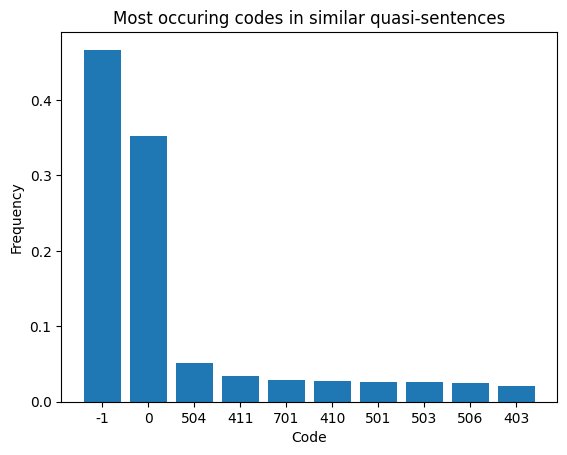

In [131]:
# Plot the most occuring codes:
top_ten_codes = code_combinations_df_full.head(10)["code"].astype(str)
top_ten_percentages = code_combinations_df_full.head(10)["perc_total_occurance"]

plt.bar(top_ten_codes, top_ten_percentages)

plt.xlabel('Code')
plt.ylabel('Frequency')
plt.title('Most occuring codes in similar quasi-sentences')

In [132]:
# How often do coders agree that similar sentences have no content/useful meaning? So how often do both give 0 or -1? How often does only one give 0 or -1?

# How often does either -1 or 0 appear in one or both of the codes:
count_a = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) | (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often do both codes have either -1 or 0:
count_b = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# How often does only one code have either -1 or 0:
count_c = cosine_sim_df[(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) ^ (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))].shape[0]

# So, how often do coders disagree on these?
print(count_c/count_a)

0.09033440319222762


In [133]:
print(count_b/cosine_sim_df.shape[0])

0.6631053943395531


In [134]:
# What is the percentage of all combinations?
print(count_c/cosine_sim_df.shape[0])

0.06584972572494506


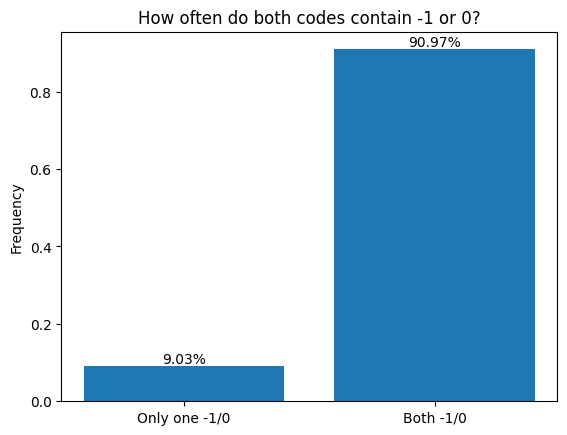

In [135]:
x = ["Only one -1/0", "Both -1/0"]
y = [count_c/count_a, 1-count_c/count_a]

plt.bar(x, y)

plt.ylabel('Frequency')
plt.title('How often do both codes contain -1 or 0?')

# Annotate the bars with their corresponding values
for i in range(len(x)):
    plt.text(i, y[i], f'{y[i]*100:.2f}%', ha='center', va='bottom')

plt.show()

--> In about 91% of the time, coders agree if there is no meaning in a q_sentence. 9% of the time, one of them sees a meaning!

Removing rows where coders agree on -1 or 0 (so that this q_sentence has no "meaning" per se):

This removes 251.679 combinations, or 66.3% of all combinations

In [136]:
# Remove all rows where both codes are -1; here the coders agree that it is not a topic that needs to be coded, likely just formating etc.
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != -1) | (cosine_sim_df['main_codes_y'] != -1)]
# same thing for both codes 0
#cosine_sim_df = cosine_sim_df[(cosine_sim_df['main_codes_x'] != 0) | (cosine_sim_df['main_codes_y'] != 0)]


# and now also where one is -1 and one is 0: the coders agree, there is no meaning in this

# This does it all in one: removes all rows where both codes are either 0 or -1:
cosine_sim_df = cosine_sim_df[~(((cosine_sim_df['main_codes_x'] == -1) | (cosine_sim_df['main_codes_x'] == 0)) & (
    (cosine_sim_df['main_codes_y'] == -1) | (cosine_sim_df['main_codes_y'] == 0)))]


cosine_sim_df.shape

(127867, 25)

How often do coders disagree on these similar sentences?

In [137]:
# add a column that indicates if coders agreed
cosine_sim_df["in_agreement"] = cosine_sim_df['main_codes_x'] == cosine_sim_df['main_codes_y']

In [138]:
cosine_sim_df.head(1)

,index_x,index_y,cosine_similarity,q_sentence_x,q_sentence_nr_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,countryname_x,partyname_x,RILE_x,q_sentence_y,q_sentence_nr_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y,in_agreement
22,8,19,1.0,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,9,706,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,20,706,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,True


In [139]:
# How often are codes not equal?
1 - sum(cosine_sim_df["in_agreement"])/cosine_sim_df.shape[0]

0.4453690162434405

In [140]:
cosine_sim_df[cosine_sim_df["cosine_similarity"] > 0.975][["coderid_x", "manifesto_id_x", "q_sentence_nr_x", "q_sentence_x", "main_codes_x",
                                                           "q_sentence_y", "main_codes_y", "manifesto_id_y", "q_sentence_nr_y", "coderid_y"]].head(10)

,coderid_x,manifesto_id_x,q_sentence_nr_x,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,manifesto_id_y,q_sentence_nr_y,coderid_y
22,102,51421_199705,9,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706,51421_199705,20,102
44,102,51421_199705,11,- Increase funding for books and equipment in schools.,506,- Increase funding for books and equipment in schools.,506,51421_199705,53,102
45,102,51421_199705,12,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",-1,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",506,51421_199705,54,102
48,102,51421_199705,15,- Boost chances for all adults to improve their skills and get better qualifications.,506,- Boost chances for all adults to improve their skills and get better qualifications.,411,51421_199705,106,102
191,102,51421_199705,19,We will:,-1,We will:,703,53620_201602,548,280
493,102,51421_199705,30,We will:,-1,We will:,703,53620_201602,548,280
808,102,51421_199705,52,We will:,-1,We will:,703,53620_201602,548,280
1107,102,51421_199705,64,We will:,-1,We will:,703,53620_201602,548,280
1420,102,51421_199705,89,We will:,-1,We will:,703,53620_201602,548,280
1764,102,51421_199705,127,We will:,-1,We will:,703,53620_201602,548,280


How often do coders agree on the same codes? Does this change as the cosine similarity increases?

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_2276\2449002681.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_2276\2449002681.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


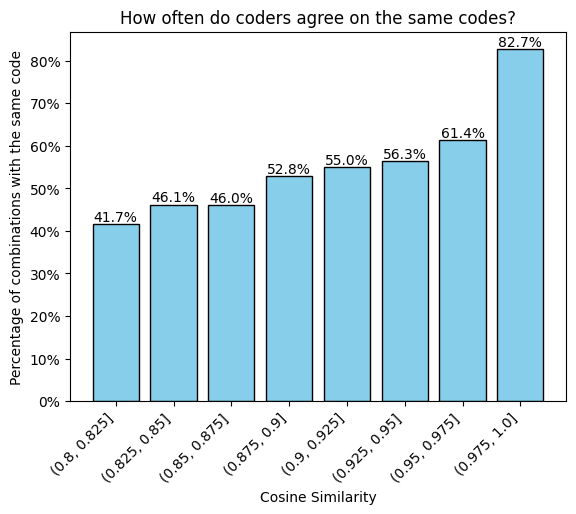

In [141]:
# Define the bins for column A
plot_df = cosine_sim_df.copy()

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of combinations with the same code')
plt.title('How often do coders agree on the same codes?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

In [142]:
plot_df = cosine_sim_df.copy()
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]

(92738, 26)


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_2276\2374201835.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_2276\2374201835.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


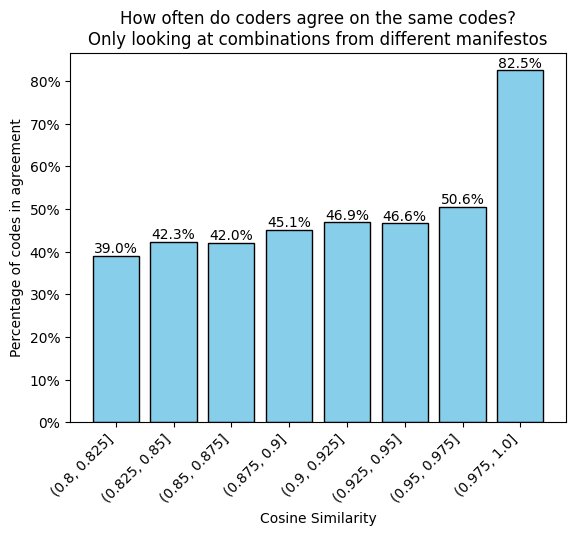

In [143]:
# How does this change if we only take combinations of different documents?
# (So coders dont just pick the same code for the sentence they see again and again?)

# Define the bins for column A
plot_df = cosine_sim_df.copy()
# remove combinations from the same document:
plot_df = plot_df[cosine_sim_df["manifesto_id_x"] != cosine_sim_df["manifesto_id_y"]]
print(plot_df.shape)

bins = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]

# Create a new column 'Bin' which indicates the bin that each value in column A falls into
plot_df['Bin'] = pd.cut(plot_df['cosine_similarity'], bins)

# Calculate the percentage of True values in each bin
bin_percentages = plot_df.groupby('Bin')['in_agreement'].mean() * 100

# Create a bar plot
bars = plt.bar(bin_percentages.index.astype(str), bin_percentages, color='skyblue', edgecolor='black')

# Add percentage labels above the bars
for bar, percentage in zip(bars, bin_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Percentage of codes in agreement')
plt.title('How often do coders agree on the same codes?\nOnly looking at combinations from different manifestos')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
# Add '%' sign to the y-axis labels
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

In [144]:
# Having a look at certain cosine similarity ranges:

cosine_sim_df[(cosine_sim_df['cosine_similarity'] >= 0.95) & (cosine_sim_df['cosine_similarity'] <= 0.975)].head(10)[["coderid_x", "manifesto_id_x", "q_sentence_nr_x", "q_sentence_x", "main_codes_x",
                                                           "q_sentence_y", "main_codes_y", "manifesto_id_y", "q_sentence_nr_y", "coderid_y"]]

,coderid_x,manifesto_id_x,q_sentence_nr_x,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,manifesto_id_y,q_sentence_nr_y,coderid_y
46,102,51421_199705,13,- Reduce primary school class sizes so that within 5 years no child between 5 and 11 I will need to be in a class of more than 30.,506,- Reduce primary school class sizes so that within 5 years no child between 5 and 11 will need to be in a class of more than 30.,506,51421_199705,57,102
3591,102,51421_199705,266,and reduce global warming emissions.,501,and reduce greenhouse gas emissions.,501,62320_201510,323,106
3592,102,51421_199705,266,and reduce global warming emissions.,501,and reduce carbon pollution.,501,62420_201510,584,106
6275,102,51421_199705,478,- End the two-tier system in the NHS.,503,- End the built-in two-tier service in the NHS.,503,51421_199705,487,102
9820,102,51421_199705,673,"We will replace Income Support and Family Credit with a simpler, more efficient Low Income Benefit that increases financial incentives for people going back to work.",402,"We will replace Income Support and Family Credit with a simpler, more efficient Low Income Benefit that helps people back to work.",303,51421_199705,727,102
11277,102,51421_199705,777,Ethnic minorities,-1,"ethnic minorities,",503,51320_201505,860,319
16237,109,51320_200106,382,Transport.,-1,transport,416,53520_200705,1793,280
16330,109,51320_200106,517,Housing.,-1,housing,504,51320_201912,1739,319
16456,109,51320_200106,736,Teachers.,-1,Teachers,506,51902_200106,160,108
16735,109,51320_200106,786,But there is a lot more to do.,504,But there is more to do.,504,63320_201607,542,342


In [145]:
cosine_sim_df[(cosine_sim_df['cosine_similarity'] >= 0.975) & (cosine_sim_df['cosine_similarity'] <= 1.1)].head(10)[["cosine_similarity","coderid_x", "manifesto_id_x", "q_sentence_nr_x", "q_sentence_x", "main_codes_x",
                                                           "q_sentence_y", "main_codes_y", "manifesto_id_y", "q_sentence_nr_y", "coderid_y"]]

,cosine_similarity,coderid_x,manifesto_id_x,q_sentence_nr_x,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,manifesto_id_y,q_sentence_nr_y,coderid_y
22,1.0,102,51421_199705,9,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706,- Give children the best start by providing high quality early years education for every 3 and 4 year-old child whose parents want it.,706,51421_199705,20,102
44,1.0,102,51421_199705,11,- Increase funding for books and equipment in schools.,506,- Increase funding for books and equipment in schools.,506,51421_199705,53,102
45,1.0,102,51421_199705,12,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",-1,"In the first year, we will double spending on books and equipment to overcome the effect of recent cuts.",506,51421_199705,54,102
48,1.0,102,51421_199705,15,- Boost chances for all adults to improve their skills and get better qualifications.,506,- Boost chances for all adults to improve their skills and get better qualifications.,411,51421_199705,106,102
191,1.0,102,51421_199705,19,We will:,-1,We will:,703,53620_201602,548,280
493,1.0,102,51421_199705,30,We will:,-1,We will:,703,53620_201602,548,280
808,1.0,102,51421_199705,52,We will:,-1,We will:,703,53620_201602,548,280
1107,1.0,102,51421_199705,64,We will:,-1,We will:,703,53620_201602,548,280
1420,1.0,102,51421_199705,89,We will:,-1,We will:,703,53620_201602,548,280
1764,1.0,102,51421_199705,127,We will:,-1,We will:,703,53620_201602,548,280


Which codes appear most often? Which most often in agreement? Which most often when not in agreement?

In [146]:
codes = np.union1d(cosine_sim_df["main_codes_x"].unique(), cosine_sim_df["main_codes_y"].unique())

In [147]:
total_counts = dict()
agreement_counts = dict()
disagreement_counts = dict()
domain_agreement_counts = dict()
domain_disagreement_counts = dict()

for c in codes:
    count = ((cosine_sim_df['main_codes_x'] == c) | (cosine_sim_df['main_codes_y'] == c)).sum()
    total_counts[c] = count
    
    count = ((cosine_sim_df['main_codes_x'] == c) & (cosine_sim_df['main_codes_y'] == c)).sum()
    agreement_counts[c] = count

    count = ((cosine_sim_df['main_codes_x'] != c) ^ (cosine_sim_df['main_codes_y'] != c)).sum()
    disagreement_counts[c] = count

    domain = str(c)[0]
    # select all rows where one of the codes is c and both start with the same number as c:
    count = cosine_sim_df[((cosine_sim_df["main_codes_x"] == c) | (cosine_sim_df["main_codes_y"] == c)) &
                ((cosine_sim_df["main_codes_x"].astype(str).str[0] == domain)
                & (cosine_sim_df["main_codes_y"].astype(str).str[0] == domain))].shape[0]
    domain_agreement_counts[c] = count

    # select all rows where one of the codes is c and one is from a different domain:
    count = cosine_sim_df[((cosine_sim_df["main_codes_x"] == c) | (cosine_sim_df["main_codes_y"] == c)) &
                ~((cosine_sim_df["main_codes_x"].astype(str).str[0] == domain)
                & (cosine_sim_df["main_codes_y"].astype(str).str[0] == domain))].shape[0]
    domain_disagreement_counts[c] = count


In [148]:
# Create a dictionary with the percentage of disagreement for this code
# so disagreement_count/total_count
# also for domain disagreement

perc_dict = dict()
domain_perc_dict = dict()
for k,v in total_counts.items():
    perc_dict[k] = disagreement_counts[k]/v
    domain_perc_dict[k] = domain_disagreement_counts[k]/v

In [149]:
# Getting the dicts into a df:
merged_df = pd.merge(pd.DataFrame(list(total_counts.items()), columns=['code', 'total_counts']),
                     pd.DataFrame(list(perc_dict.items()), columns=['code', 'perc_disagree']),
                     on='code')

merged_df_temp = pd.merge(pd.DataFrame(list(agreement_counts.items()), columns=['code', 'agreement_counts']),
                     pd.DataFrame(list(disagreement_counts.items()), columns=['code', 'disagreement_counts']),
                     on='code')

code_combinations_df = pd.merge(merged_df, merged_df_temp, on='code')

merged_df_temp_2 = pd.merge(pd.DataFrame(list(domain_agreement_counts.items()), columns=['code', 'domain_agreement_counts']),
                     pd.DataFrame(list(domain_disagreement_counts.items()), columns=['code', 'domain_disagreement_counts']),
                     on='code')

merged_df_temp_3 = pd.merge(merged_df_temp_2,
                            pd.DataFrame(list(domain_perc_dict.items()), columns=['code', 'domain_perc_disagree']),
                            on='code' )

code_combinations_df = pd.merge(code_combinations_df, merged_df_temp_3, on = "code")

# add the percentage how often a code appears in the similar sentence combinations:
code_combinations_df["perc_total_occurance"] = code_combinations_df["total_counts"]/cosine_sim_df.shape[0]

code_combinations_df.sort_values(by="perc_total_occurance", ascending=False, inplace=True)

code_combinations_df.head(3)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,domain_agreement_counts,domain_disagreement_counts,domain_perc_disagree,perc_total_occurance
40,504,19339,0.418015,11255,8084,12900,6439,0.332954,0.151243
0,-1,13175,1.000000,0,13175,0,13175,1.000000,0.103037
31,411,12902,0.464812,6905,5997,8718,4184,0.324291,0.100902


In [150]:
code_combinations_df[code_combinations_df["code"] == 702]

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,domain_agreement_counts,domain_disagreement_counts,domain_perc_disagree,perc_total_occurance
53,702,395,0.382278,244,151,266,129,0.326582,0.003089


In [151]:
code_combinations_df[code_combinations_df["perc_disagree"] < 0.5]

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,domain_agreement_counts,domain_disagreement_counts,domain_perc_disagree,perc_total_occurance
40,504,19339,0.418015,11255,8084,12900,6439,0.332954,0.151243
31,411,12902,0.464812,6905,5997,8718,4184,0.324291,0.100902
52,701,11111,0.441364,6207,4904,6385,4726,0.425344,0.086895
54,703,6804,0.431511,3868,2936,3933,2871,0.421958,0.053212
48,605,5102,0.477656,2665,2437,2878,2224,0.435907,0.039901
5,104,3734,0.466256,1993,1741,2159,1575,0.421800,0.029202
53,702,395,0.382278,244,151,266,129,0.326582,0.003089


In [152]:
#example for 408
#cosine_sim_df[(cosine_sim_df["main_codes_x"] == 408) & (cosine_sim_df["main_codes_y"] != 408)].head(20)

In [153]:
# testing if the numbers make sense
#cosine_sim_df[(cosine_sim_df["main_codes_x"] == 702) & (cosine_sim_df["main_codes_y"] == 702)].shape
# total counts is all combinations * 2 (as each comb has two codes) - the number of combinations that are in agreement (as here only one code appears)
sum(code_combinations_df["total_counts"])

184815

In [154]:
cosine_sim_df.shape[0]*2 - sum(code_combinations_df["agreement_counts"])

184815

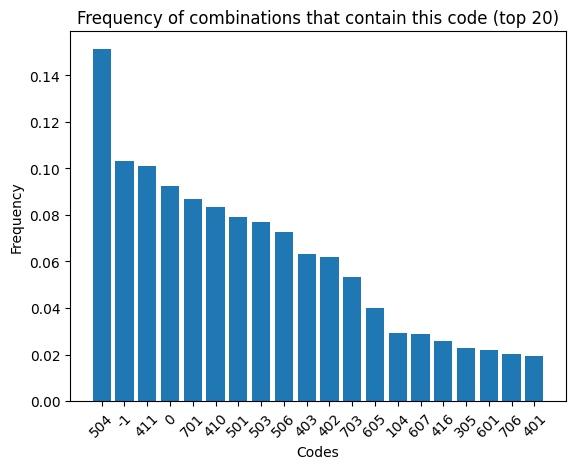

In [156]:
# Plot the most occuring codes:
code_combinations_df.sort_values(by="perc_total_occurance", ascending=False, inplace=True)

top_ten_codes = code_combinations_df.head(20)["code"].astype(str)
top_ten_percentages = code_combinations_df.head(20)["perc_total_occurance"]

plt.bar(top_ten_codes, top_ten_percentages)

plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.title('Frequency of combinations that contain this code (top 20)')
plt.xticks(rotation=45)
plt.show()

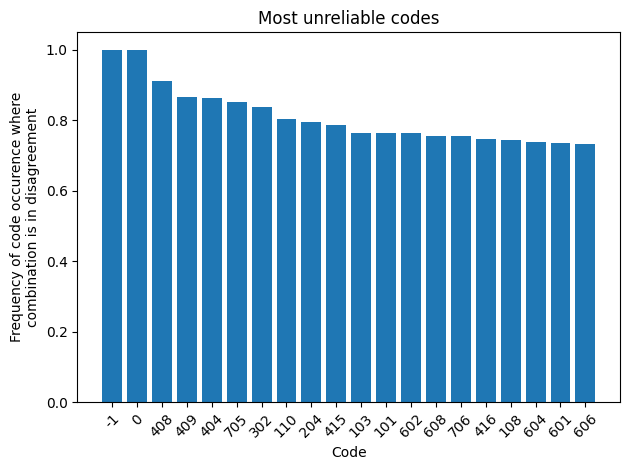

In [157]:
# Similar thing, but sorted by codes that are the most contentious:
code_combinations_df.sort_values(by="perc_disagree", ascending=False, inplace=True)

# Plot the most occuring codes:
top_ten_codes = code_combinations_df.head(20)["code"].astype(str)
top_ten_percentages = code_combinations_df.head(20)["perc_disagree"]
top_ten_total_counts = code_combinations_df.head(20)["total_counts"]

bars = plt.bar(top_ten_codes, top_ten_percentages)

# Add total counts as text on top of each bar
# for bar, count in zip(bars, top_ten_total_counts):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
#              ha='center', va='bottom', rotation = 45)

plt.xlabel('Code')
plt.ylabel('Frequency of code occurence where\ncombination is in disagreement')
plt.title('Most unreliable codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

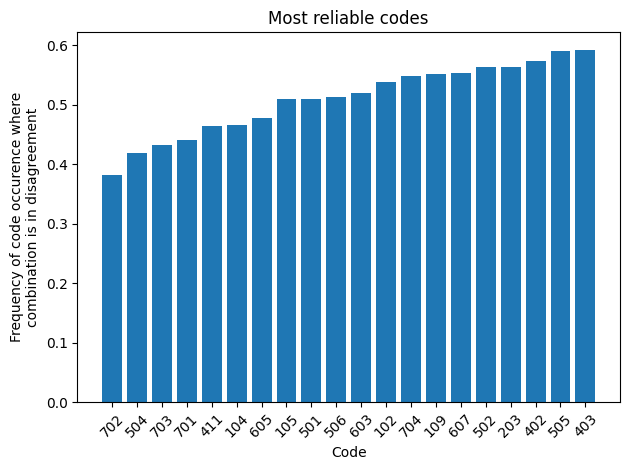

In [158]:
# Same thing, but sorted by codes that are the least contentious:
code_combinations_df.sort_values(by="perc_disagree", ascending=True, inplace=True)

# Plot the most occuring codes:
top_ten_codes = code_combinations_df.head(20)["code"].astype(str)
top_ten_percentages = code_combinations_df.head(20)["perc_disagree"]
top_ten_total_counts = code_combinations_df.head(20)["total_counts"]

bars = plt.bar(top_ten_codes, top_ten_percentages)

# Add total counts as text on top of each bar
# for bar, count in zip(bars, top_ten_total_counts):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
#              ha='center', va='bottom', rotation = 45)

plt.xlabel('Code')
plt.ylabel('Frequency of code occurence where\ncombination is in disagreement')
plt.title('Most reliable codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [95]:
code_combinations_df.head(10)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,perc_total_occurance
53,702,395,0.382278,244,151,0.003089
40,504,19339,0.418015,11255,8084,0.151243
54,703,6804,0.431511,3868,2936,0.053212
52,701,11111,0.441364,6207,4904,0.086895
31,411,12902,0.464812,6905,5997,0.100902
5,104,3734,0.466256,1993,1741,0.029202
48,605,5102,0.477656,2665,2437,0.039901
6,105,259,0.509653,127,132,0.002026
37,501,10107,0.510339,4949,5158,0.079043
42,506,9300,0.513333,4526,4774,0.072732


In [177]:
len(code_combinations_df["code"].unique())

58

What about getting at least the domain right? What codes actually switch domain often?

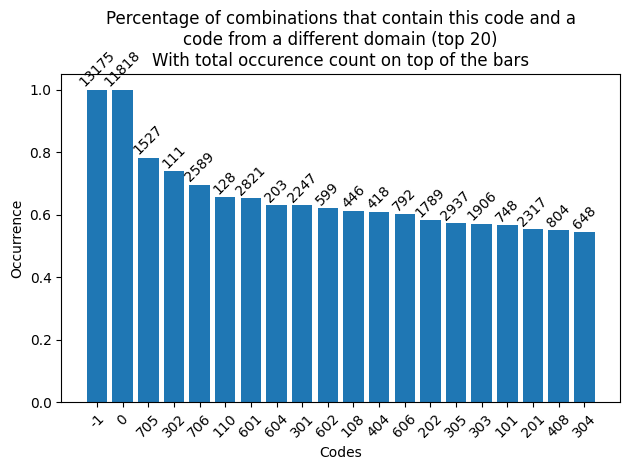

In [179]:
# Same thing, but sorted by codes that most often change domains:
code_combinations_df.sort_values(by="domain_perc_disagree", ascending=False, inplace=True)

# Plot the most occuring codes:
x = 20
top_ten_codes = code_combinations_df.head(x)["code"].astype(str)
top_ten_percentages = code_combinations_df.head(x)["domain_perc_disagree"]
top_ten_total_counts = code_combinations_df.head(x)["total_counts"]

bars = plt.bar(top_ten_codes, top_ten_percentages)

# Add total counts as text on top of each bar
for bar, count in zip(bars, top_ten_total_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', rotation = 45)

plt.xlabel('Codes')
plt.ylabel('Occurrence')
plt.title('Percentage of combinations that contain this code and a\ncode from a different domain (top 20)\nWith total occurence count on top of the bars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

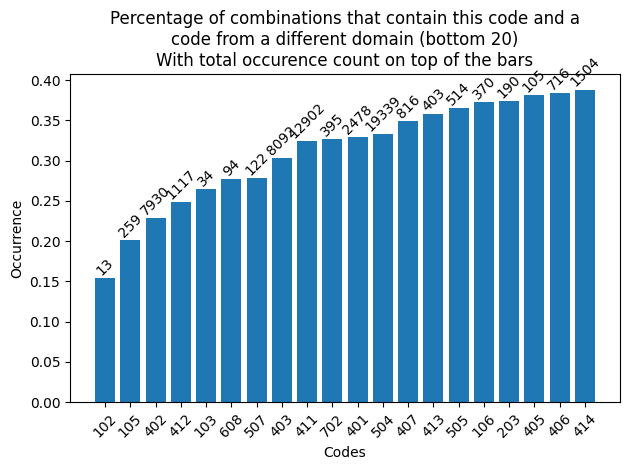

In [174]:
# Same thing, but sorted by codes that least often change domains:
code_combinations_df.sort_values(by="domain_perc_disagree", ascending=True, inplace=True)

# Plot the most occuring codes:
top_ten_codes = code_combinations_df.head(20)["code"].astype(str)
top_ten_percentages = code_combinations_df.head(20)["domain_perc_disagree"]
top_ten_total_counts = code_combinations_df.head(20)["total_counts"]

bars = plt.bar(top_ten_codes, top_ten_percentages)

# Add total counts as text on top of each bar
for bar, count in zip(bars, top_ten_total_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', rotation = 45)

plt.xlabel('Codes')
plt.ylabel('Occurrence')
plt.title('Percentage of combinations that contain this code and a\ncode from a different domain (bottom 20)\nWith total occurence count on top of the bars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [169]:
code_combinations_df.head(10)

,code,total_counts,perc_disagree,agreement_counts,disagreement_counts,domain_agreement_counts,domain_disagreement_counts,domain_perc_disagree,perc_total_occurance
0,-1,13175,1.000000,0,13175,0,13175,1.000000,0.103037
1,0,11818,1.000000,0,11818,0,11818,1.000000,0.092424
56,705,1527,0.852652,225,1302,332,1195,0.782580,0.011942
17,302,111,0.837838,18,93,29,82,0.738739,0.000868
57,706,2589,0.755118,634,1955,787,1802,0.696022,0.020248
11,110,128,0.804688,25,103,44,84,0.656250,0.001001
44,601,2821,0.735555,746,2075,980,1841,0.652605,0.022062
47,604,203,0.738916,53,150,75,128,0.630542,0.001588
16,301,2247,0.680463,718,1529,833,1414,0.629283,0.017573
45,602,599,0.762938,142,457,227,372,0.621035,0.004685


Deeper look into sentences that are exactly the same:

In [180]:
same_df = cosine_sim_df[cosine_sim_df["q_sentence_x"] == cosine_sim_df["q_sentence_y"]]
same_df.shape

(26653, 26)

In [181]:
# how often are the codes the same?
same_df[same_df["main_codes_x"] == same_df["main_codes_y"]].shape[0]/same_df.shape[0]

0.8937455445916032

In [185]:
same_df[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y",
         "cosine_similarity"]].sort_values(by="cosine_similarity", ascending=True).head(5)

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,cosine_similarity
229978,We are restoring honesty and fairness to the workplace relations system.,702,We are restoring honesty and fairness to the workplace relations system.,702,1.0
282700,By 2020-21 we will have restored Defence investment to 2 per cent of GDP.,104,By 2020-21 we will have restored Defence investment to 2 per cent of GDP.,104,1.0
139847,There is an urgent need to modernize the federal government's legacy systems,411,There is an urgent need to modernize the federal government's legacy systems,411,1.0
221733,$80 million to build the North Lake Bridge.,411,$80 million to build the North Lake Bridge.,411,1.0
140480,"Thirty years ago, the world’s estimated reserves of oil were 645 billion barrels.",411,"Thirty years ago, the world’s estimated reserves of oil were 645 billion barrels.",411,1.0


In [191]:
same_tmp_df = same_df[same_df["main_codes_x"] != same_df["main_codes_y"]]
same_tmp_df.tail(20)[["q_sentence_x", "main_codes_x", "q_sentence_y", "main_codes_y",
         "cosine_similarity"]]

,q_sentence_x,main_codes_x,q_sentence_y,main_codes_y,cosine_similarity
374831,Fighting crime,-1,Fighting crime,605,1.0
375244,poverty and,410,poverty and,503,1.0
375960,"industrial diversification,",410,"industrial diversification,",411,1.0
376312,Together we move South Africa forward.,606,Together we move South Africa forward.,202,1.0
376348,"Codify the exceptions to the 1913 cut-off date for the descendants of the Khoi and San, and identify affected heritage sites and historical landmarks.",706,"Codify the exceptions to the 1913 cut-off date for the descendants of the Khoi and San, and identify affected heritage sites and historical landmarks.",303,1.0
377241,Ensuring that state-funded schooling options are available for learners with a wide range of special needs.,705,Ensuring that state-funded schooling options are available for learners with a wide range of special needs.,504,1.0
377332,TODAY we are calling on you to SAVE SOUTH AFRICA.,601,TODAY we are calling on you to SAVE SOUTH AFRICA.,202,1.0
377706,"stability,",106,"stability,",305,1.0
377714,"stability,",106,"stability,",305,1.0
377863,The motion was adopted by the Council.,701,The motion was adopted by the Council.,503,1.0


In [22]:
test = cosine_sim_df[(cosine_sim_df["main_codes_x"] == 416) & (cosine_sim_df["main_codes_y"] == 501)]

In [25]:
test.head(50)

,index_x,index_y,cosine_similarity,q_sentence_x,q_sentence_nr_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,countryname_x,partyname_x,RILE_x,q_sentence_y,q_sentence_nr_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y
18380,4324,78578,0.802572,that will ensure our coastal communities are able to benefit from sustainable fisheries.,743,416,108,51902_200106,51902,200106,Heart of the manifesto 2001,United Kingdom,Scottish National Party,0,"We will support healthy coastal communities and marine ecosystems to sustain and enhance our economic well-being,",1520,501,353,61320_202011,61320,202011,2020 Democratic Party platform,United States,Democratic Party,0
18660,4510,99856,0.823943,"an economy that works for people and planet at a human scale,",61,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,an economy that meets human needs without unnecessarily damaging the natural environment.,1567,501,104,63110_201008,63110,201008,Australian Greens policy,Australia,Australian Greens,0
18838,4822,20472,0.805737,"Soil erosion, depletion of water resources, pollution, loss of biodiversity and animal suffering are commonplace.",373,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,and the degradation of habitat and loss of species.,694,501,340,51620_201706,51620,201706,"Forward, together. Our plan for a stronger Britain and a prosperous future. The Conservative and Unionist Party manifesto 2017",United Kingdom,Conservative Party,0
18840,4823,160635,0.859253,"In addition, agriculture accounts for a significant proportion of greenhouse gas emissions,",374,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,Nearly half of our greenhouse gases come from agriculture.,3173,501,201,64110_201409,64110,201409,Green Party election priority,New Zealand,Green Party of Aotearoa New Zealand,0
18915,4924,13713,0.814349,We oppose nuclear power,475,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,"We continue to oppose the building of nuclear power plants in new locations,",691,501,319,51901_201505,51901,201505,Working for Wales. 2015 Westminster Election Manifesto,United Kingdom,The Party of Wales,0
18916,4924,137267,0.892554,We oppose nuclear power,475,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,We oppose nuclear fission power stations.,161,501,804,64951_198407,64951,198407,Policy in brief,New Zealand,Social Credit Political League,0
19110,5134,98731,0.842206,Ban other new fossil fuel developments such as other unconventional fossil fuels and open cast coal.,685,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,ban public funding to refurbish any existing coal fired power stations.,442,501,104,63110_201008,63110,201008,Australian Greens policy,Australia,Australian Greens,0
19111,5134,157161,0.814782,Ban other new fossil fuel developments such as other unconventional fossil fuels and open cast coal.,685,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,Ban deep sea oil exploration and drilling.,208,501,201,64902_201111,64902,201111,Mana Party policy statements,New Zealand,Mana Party,0
19112,5134,179341,0.801897,Ban other new fossil fuel developments such as other unconventional fossil fuels and open cast coal.,685,416,319,51110_201505,51110,201505,For the common good. General election manifesto 2015,United Kingdom,Green Party of England and Wales,0,Ban seabed mining and seismic surveying for mine

In [86]:
# testing domain confusion matrix
both = cosine_sim_df[(cosine_sim_df["main_codes_x"]>=700) & (cosine_sim_df["main_codes_y"]>=700)].shape[0]
all = cosine_sim_df[(cosine_sim_df["main_codes_x"]>=700) | (cosine_sim_df["main_codes_y"]>=700)].shape[0]
both/all

0.5157401205626256

In [ ]:
cosine_sim_df[(cosine_sim_df["main_codes_x"]>=700) | (cosine_sim_df["main_codes_y"]>=700)].shape[0]

In [97]:
cosine_sim_df.head(5)

,index_x,index_y,cosine_similarity,q_sentence_x,q_sentence_nr_x,main_codes_x,coderid_x,manifesto_id_x,party_x,date_x,title_x,countryname_x,partyname_x,RILE_x,q_sentence_y,q_sentence_nr_y,main_codes_y,coderid_y,manifesto_id_y,party_y,date_y,title_y,countryname_y,partyname_y,RILE_y,domain_x,domain_y
0,7,9,0.851987,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Key priorities are to:,10,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,0,0
1,7,119,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,120,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,0,0
2,7,215,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,216,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,0,0
3,7,330,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,331,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,0,0
4,7,472,0.903366,Our first priority is to:,8,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,Our priorities are to:,473,-1,102,51421_199705,51421,199705,Make the Difference,United Kingdom,Liberal Democrats,0,0,0


In [93]:
(cosine_sim_df["main_codes_x"]/100).astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
379541    5
379542    6
379543    0
379544    0
379545    6
Name: main_codes_x, Length: 379546, dtype: int32

In [96]:
cosine_sim_df["domain_x"] = (cosine_sim_df["main_codes_x"]/100).astype(int)
cosine_sim_df["domain_y"] = (cosine_sim_df["main_codes_y"]/100).astype(int)

In [98]:
cosine_sim_df["domain_x"].value_counts()

domain_x
0    264549
5     37742
4     36358
7     16606
6     10103
1      5829
3      5349
2      3010
Name: count, dtype: int64

In [108]:
confusion_matrix = pd.crosstab(cosine_sim_df['domain_x'], cosine_sim_df['domain_y'])

In [109]:
confusion_matrix

domain_y,0,1,2,3,4,5,6,7
domain_x,,,,,,,,
0,251679,415,364,742,3100,5553,1147,1549
1,505,3855,146,65,483,280,294,201
2,291,120,1818,136,83,218,224,120
3,750,58,133,3045,581,375,268,139
4,2702,639,132,682,26864,2192,711,2436
5,5207,161,228,336,2232,27645,826,1107
6,1166,273,208,232,622,799,6566,237
7,1502,161,102,120,1489,1256,426,11550
